# Glove

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, classification_report

from imblearn.over_sampling import RandomOverSampler
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [2]:
df = pd.read_csv("augmented_fake_job_postings.xls")[['description', 'fraudulent']]
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [3]:
def process_text(text):
    return re.sub(r'[^a-zA-Z\s]', ' ', text).lower()

df['description'] = df['description'].apply(process_text)

# 4. Handle imbalance
X = df[['description']]
y = df['fraudulent']
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_resampled['description'])
sequences = tokenizer.texts_to_sequences(X_resampled['description'])
padded_sequences = pad_sequences(sequences, padding='post', maxlen=50)

x = np.array(padded_sequences)
y = np.array(y_resampled)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)

In [5]:
embedding_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coeffs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coeffs

In [6]:
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [7]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=50,
                    trainable=False))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     6,911,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,911,200 (26.36 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 6,911,200 (26.36 MB)

In [8]:
history = model.fit(x_train, y_train, epochs=6, batch_size=32, validation_split=0.1)

Epoch 1/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7135 - loss: 0.5428 - val_accuracy: 0.9220 - val_loss: 0.2237
Epoch 2/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9457 - loss: 0.1489 - val_accuracy: 0.9668 - val_loss: 0.0853
Epoch 3/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9902 - loss: 0.0363 - val_accuracy: 0.9867 - val_loss: 0.0468
Epoch 4/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - accuracy: 0.9961 - loss: 0.0178 - val_accuracy: 0.9875 - val_loss: 0.0414
Epoch 5/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.9961 - loss: 0.0146 - val_accuracy: 0.9772 - val_loss: 0.0671
Epoch 6/6
678/678 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.9971 - loss: 0.0121 - val_accuracy: 0.9851 - val_loss: 0.0526


In [9]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {accuracy * 100:.4f}%")

y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int)

133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9806 - loss: 0.0628

Test Accuracy: 98.2361%
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step


In [10]:
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.4f}%")
print(f"Recall: {recall_score(y_test, y_pred) * 100:.4f}%")
print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.4f}%")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.4f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 98.2361%
Recall: 100.0000%
F1 Score: 98.2849%
Precision: 96.6277%

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      2103
           1       0.97      1.00      0.98      2149

    accuracy                           0.98      4252
   macro avg       0.98      0.98      0.98      4252
weighted avg       0.98      0.98      0.98      4252



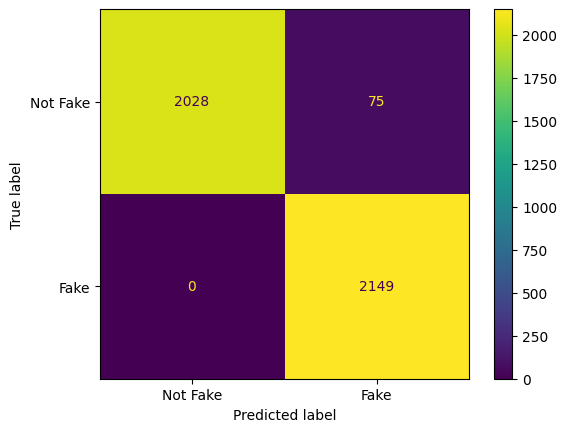

In [11]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Not Fake', 'Fake']).plot()
plt.show()

In [12]:
# 13. Predicting on new job descriptions
def process_and_predict(text):
    cleaned_text = process_text(text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded = pad_sequences(seq, maxlen=50, padding='post')
    pred_prob = model.predict(padded)[0][0]
    prediction = "FAKE (Fraudulent Posting)" if pred_prob > 0.5 else "REAL (Legitimate Posting)"
    confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob
    return prediction, round(confidence * 100, 2)

In [13]:
new_description = """Company: JUSPAY 
Role: Software Development Engineer Intern 
Location: Bangalore, India 
Batch: 2026/2025/2024"""
prediction, confidence = process_and_predict(new_description)

print(f"\nJob Description Prediction: {prediction}")
print(f"Confidence: {confidence}%")
# Save Keras model in native format
pickle.dump(model,open("Glove.pkl","wb"))
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Job Description Prediction: REAL (Legitimate Posting)
Confidence: 99.87%
